## Churn modelling for telco dataset from Kaggle

## Structure

      

- Data Processing
    - Dummify
    - Cleanup upper/lowercase
    - Format

  
- Data Exploration
    - Plot multigrid nummerical variables
    - Plot kategoriske variable 

- Train, Test split

- Modelling
 
- Evaluation
    - Confusion matrix
    - ROC curve


- Next steps












## Import

In [41]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

import seaborn as sns

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score


In [17]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

## Load data

Data taken from https://github.com/nikhilsthorat03/Telco-Customer-Churn/blob/main/telco.csv

In [18]:
df=pd.read_csv("telco.csv")
df.head()

,Unnamed: 0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,Stayed
1,1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,Stayed
2,2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Churned
3,3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,Stayed
4,4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Churned


In [19]:
df.columns

Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn'],
      dtype='object')

In [20]:
df.Churn.unique()

array(['Stayed', 'Churned'], dtype=object)

In [21]:
len(df)

7043

## Target creation

In [22]:
df['Churn_target']=df['Churn'].apply(lambda x: 1 if x=='Churned' else 0)
churned_customers=df[df['Churn_target']==1]
non_churned_customers=df[df['Churn_target']==0]
print('number of churned customers ',len(churned_customers),' number of non churners ',len(non_churned_customers))
df[['Churn_target','Churn']][0:5]

number of churned customers  1869  number of non churners  5174


,Churn_target,Churn
0,0,Stayed
1,0,Stayed
2,1,Churned
3,0,Stayed
4,1,Churned


## Data cleanup

### Formatting

In [23]:
df['TotalCharges'].dtypes

dtype('O')

In [24]:
df['TotalCharges']=df['TotalCharges'].apply(lambda x: np.nan if x==" " else x)
df['TotalCharges_num']=pd.to_numeric(df.TotalCharges)
df[['TotalCharges','TotalCharges_num']].dtypes

TotalCharges         object
TotalCharges_num    float64
dtype: object

### upper/lower case cleanup

In [25]:
df['InternetService']=df['InternetService'].str.lower()
df['InternetService'].unique()

array(['dsl', 'fiber optic', 'no'], dtype=object)

## Data exploration

In [26]:
df.columns

Index(['Unnamed: 0', 'customerID', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'Churn', 'Churn_target', 'TotalCharges_num'],
      dtype='object')

## Plotting

In [27]:
drop_list=['Unnamed: 0', 'customerID','TotalCharges','Churn_target','Churn']
num_list=['tenure','MonthlyCharges','TotalCharges_num']
cat_list = list(set(df.columns.tolist())-set(num_list) - set(drop_list))


### Categorical variables

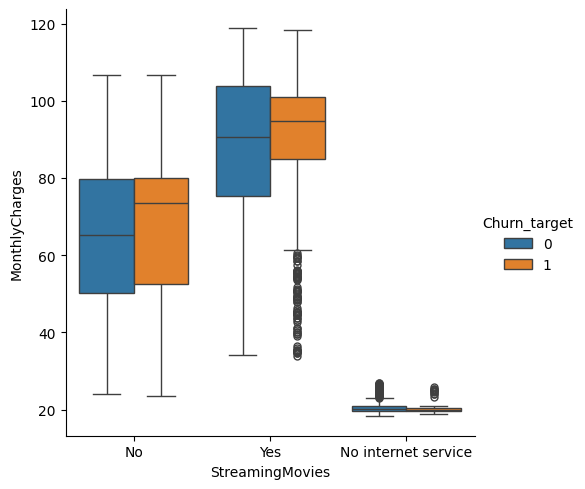

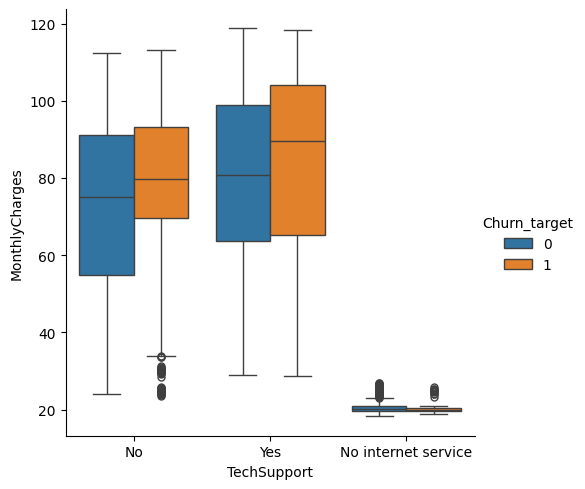

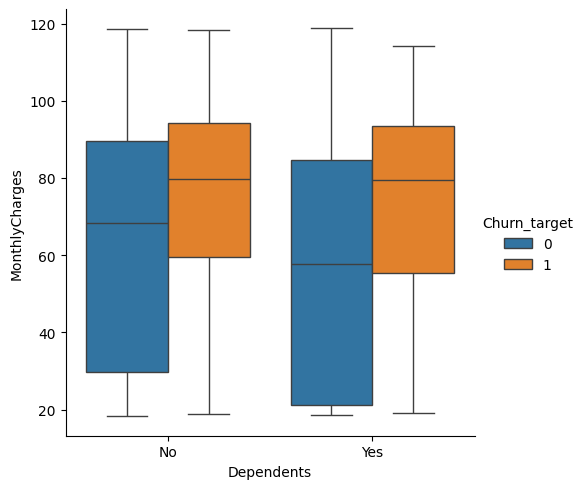

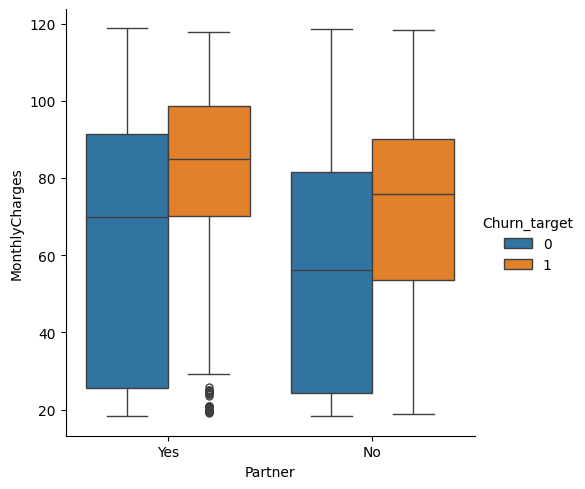

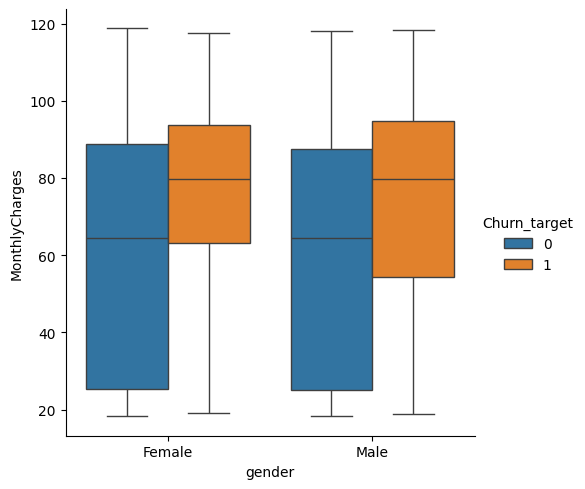

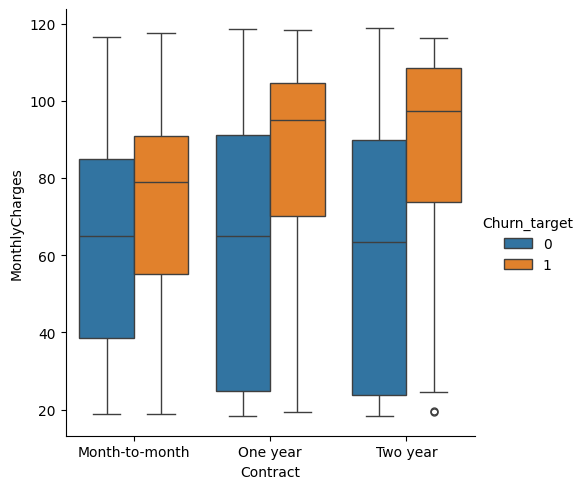

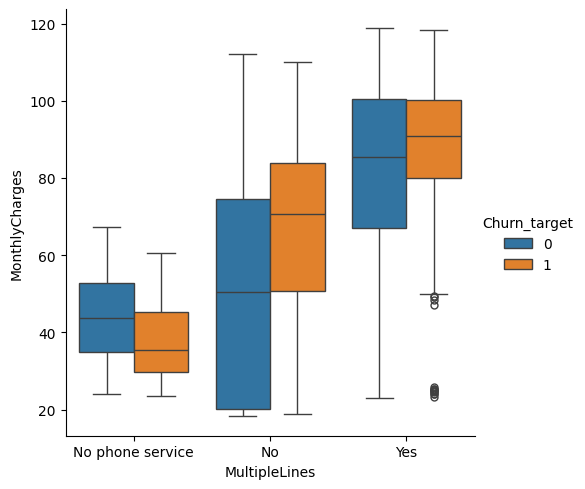

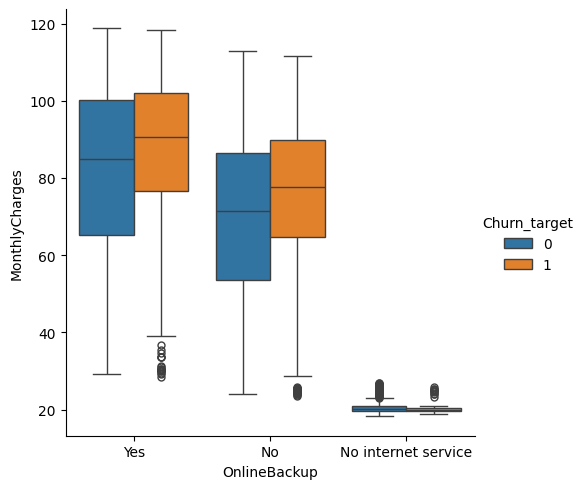

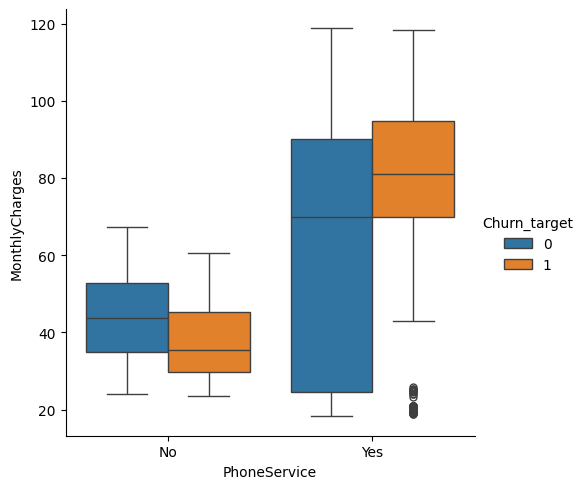

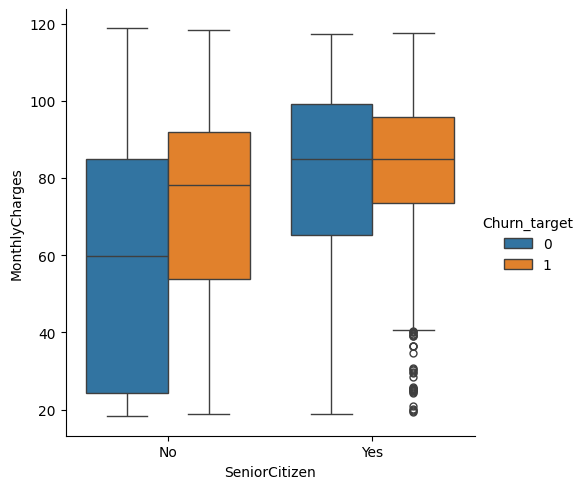

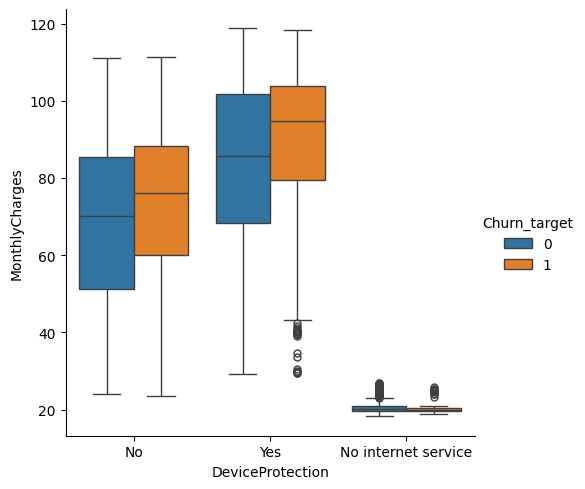

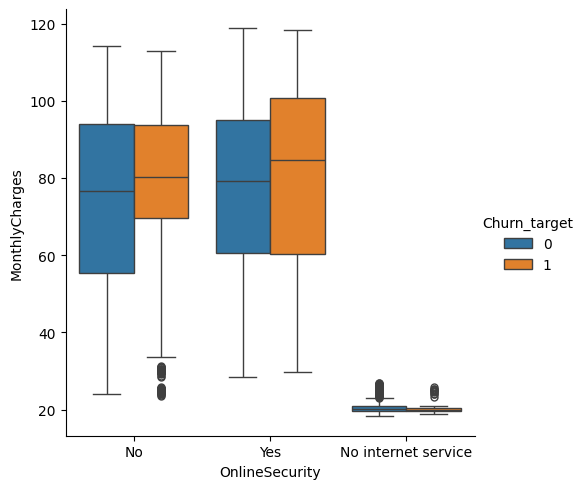

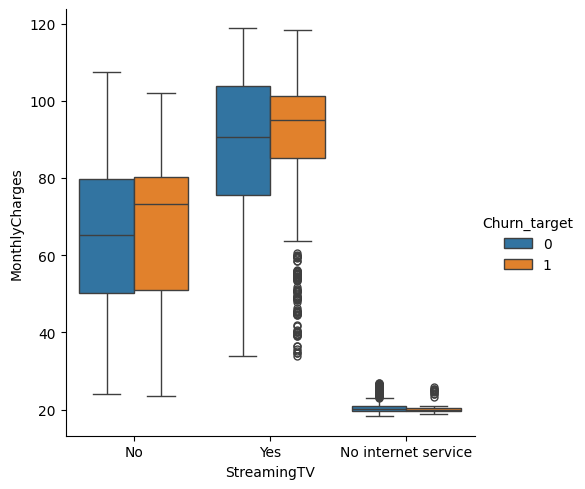

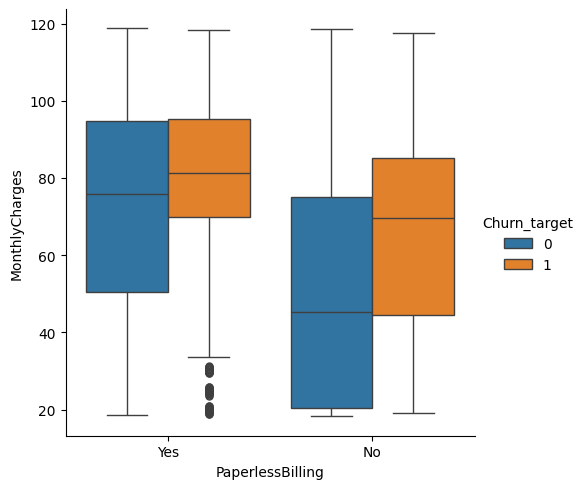

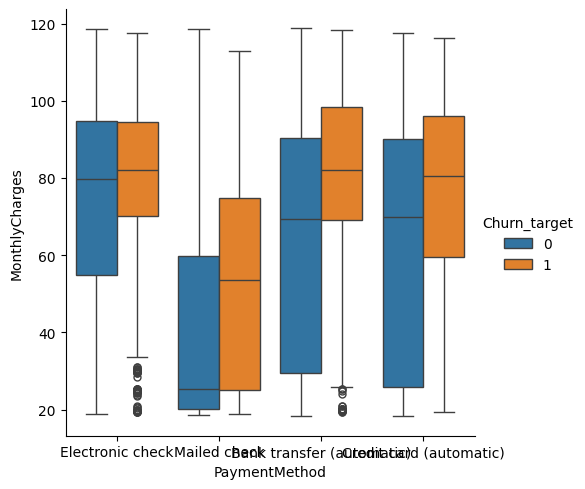

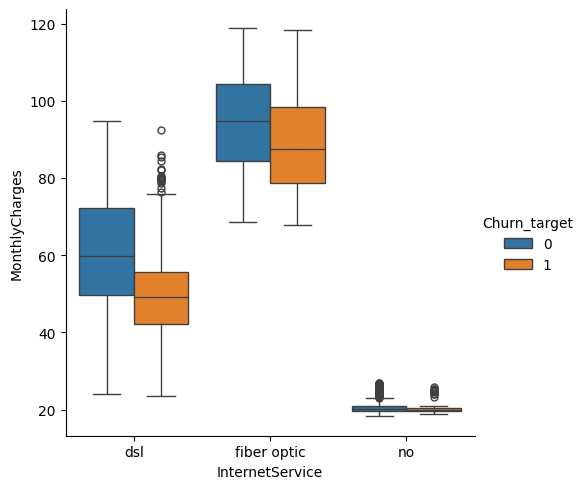

In [42]:

for var in cat_list:
    sns.catplot(data=df,x=var,y='MonthlyCharges',hue='Churn_target',kind='box')
    

### Numerical variables

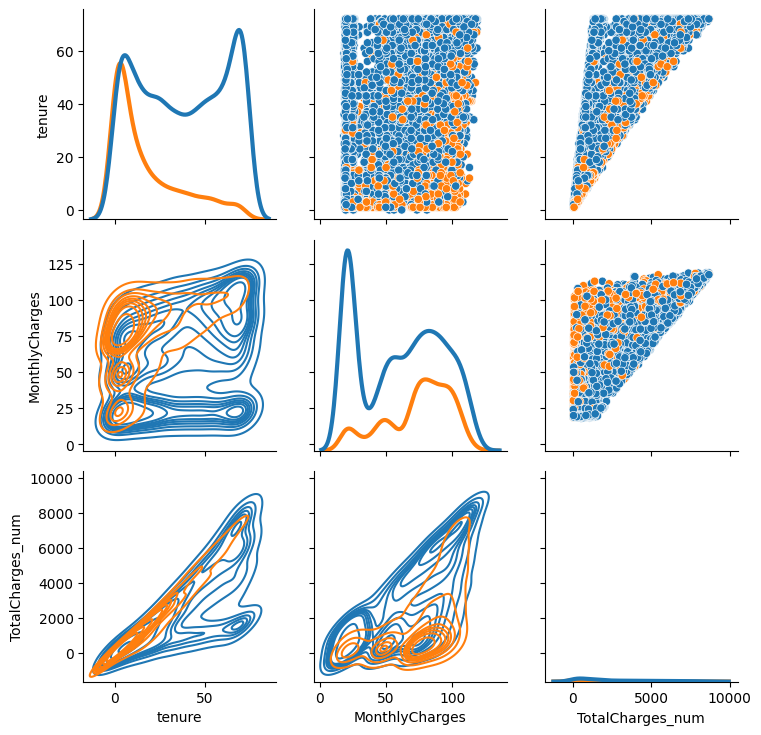

In [29]:
g = sns.PairGrid(df, vars=['tenure','MonthlyCharges','TotalCharges_num'],hue='Churn_target')
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

## Dummify

In [30]:
df_dummy=pd.get_dummies(df[cat_list])
df_dummy.head()

,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PhoneService_No,PhoneService_Yes,SeniorCitizen_No,SeniorCitizen_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_dsl,InternetService_fiber optic,InternetService_no
0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
1,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0
2,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0
3,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0
4,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0


In [31]:
keep_list=num_list+['Churn_target']
df_remainder=df[keep_list].copy()
df_remainder.columns

df_remainder.head()

,tenure,MonthlyCharges,TotalCharges_num,Churn_target
0,1,29.85,29.85,0
1,34,56.95,1889.50,0
2,2,53.85,108.15,1
3,45,42.30,1840.75,0
4,2,70.70,151.65,1


In [32]:
df_final=pd.concat([df_remainder,df_dummy], axis=1)

df_final.head()

,tenure,MonthlyCharges,TotalCharges_num,Churn_target,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PhoneService_No,PhoneService_Yes,SeniorCitizen_No,SeniorCitizen_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_dsl,InternetService_fiber optic,InternetService_no
0,1,29.85,29.85,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0
1,34,56.95,1889.50,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0
2,2,53.85,108.15,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0
3,45,42.30,1840.75,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0
4,2,70.70,151.65,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0


### Additional steps to take
- Normalize numeric variables
- Weights
- Outlier analysis


## Train, test, split

In [33]:
drop_vars=['Churn_target']

X = df_final.drop(drop_vars, axis=1)
y = df_final['Churn_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(len(X_train),len(X_test))

4718 2325


In [34]:
X_train.head()

,tenure,MonthlyCharges,TotalCharges_num,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,Dependents_No,Dependents_Yes,Partner_No,Partner_Yes,gender_Female,gender_Male,Contract_Month-to-month,Contract_One year,Contract_Two year,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,PhoneService_No,PhoneService_Yes,SeniorCitizen_No,SeniorCitizen_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_dsl,InternetService_fiber optic,InternetService_no
298,40,74.55,3015.75,0,0,1,1,0,0,0,1,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0
3318,10,29.50,255.25,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0
5586,27,19.15,501.35,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1
6654,7,86.50,582.50,1,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
5362,65,24.75,1715.10,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1


## Modelling

In [35]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Evaluation

In [36]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Initial Model Accuracy: {accuracy * 100:.2f}%")
y_pred_proba = model.predict_proba(X_test)[:, 1] 

Initial Model Accuracy: 79.14%


Note: Before dummyfication and adding TotalCharges and InternetService the accuracy was 78

## Confusion matrix

In [37]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[1503  194]
 [ 291  337]]


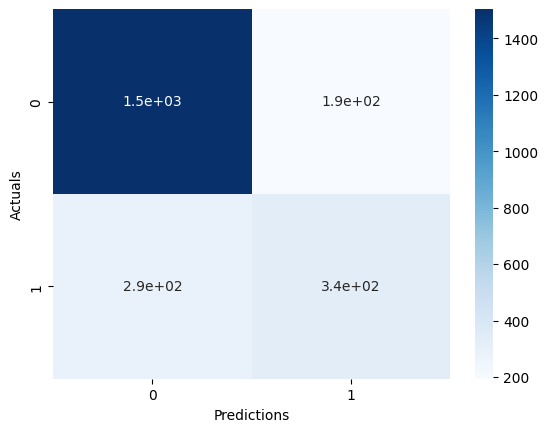

In [38]:

sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.ylabel('Actuals')
plt.xlabel('Predictions')
plt.show()

## ROC curve

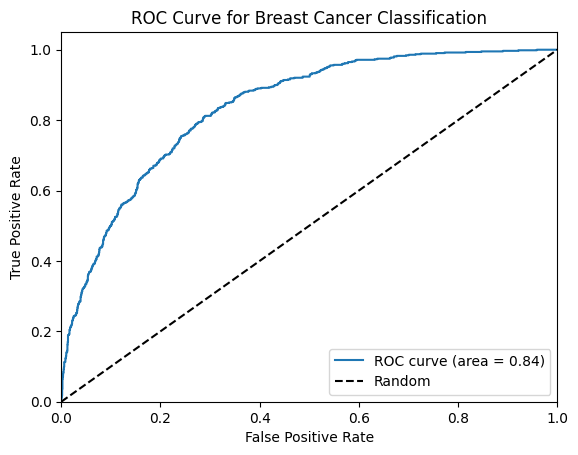

In [39]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba) 
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

## Feature Importance

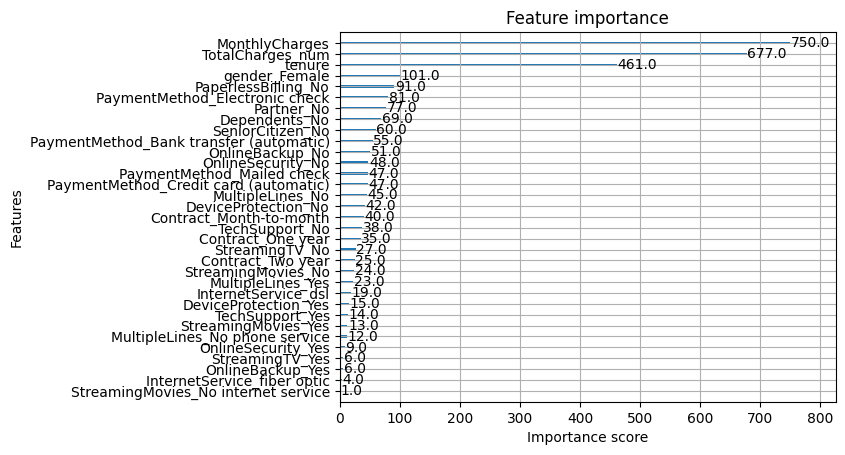

In [40]:
# plot feature importance
plot_importance(model)
plt.show()

## Next steps
- Explainabillity with SHAPly
- Clustering af mest churn prone customers
- Model tuning
- Undersøge om det giver mening at tilføje vægte til modellen
- Hvor skal churn scores leveres (typisk aftalt på forhånd)
- Model inference set-up/productionalisation


# Graveyard

In [53]:
# CHANGING THE VALUES TO NUMERICAL AS THE MODEL ONLY ACCEPTS NUMERICAL INPUTS

#Maybe just dummyfi
#this list: 
#    ['gender','SeniorCitizen','Partner','Dependents','PhoneService','PaperlessBilling','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','Contract','PaymentMethod','StreamingMovies']


df['gender'] = df['gender'].replace(['Male','Female'],[1,0])
df['SeniorCitizen'] = df['SeniorCitizen'].replace(['Yes','No'],[1,0])
df['Partner'] = df['Partner'].replace(['Yes','No'],[1,0])
df['Dependents'] = df['Dependents'].replace(['Yes','No'],[1,0])
df['PhoneService'] = df['PhoneService'].replace(['Yes','No'],[1,0])
df['PaperlessBilling'] = df['PaperlessBilling'].replace(['Yes','No'],[1,0])
df['MultipleLines'] = df['MultipleLines'].replace(['Yes','No','No phone service'],[1,0,2])
df['InternetService'] = df['InternetService'].replace(['Fiber optic','DSL','No'],[1,2,0])
df['OnlineSecurity'] = df['OnlineSecurity'].replace(['Yes','No','No internet service'],[1,0,2])
df['OnlineBackup'] = df['OnlineBackup'].replace(['Yes','No','No internet service'],[1,0,2])
df['DeviceProtection'] = df['DeviceProtection'].replace(['Yes','No','No internet service'],[1,0,2])
df['TechSupport'] = df['TechSupport'].replace(['Yes','No','No internet service'],[1,0,2])
df['StreamingTV'] = df['StreamingTV'].replace(['Yes','No','No internet service'],[1,0,2])
df['Contract'] = df['Contract'].replace(['Month-to-month','Two year','One year'],[3,2,1])
df['PaymentMethod'] = df['PaymentMethod'].replace(['Electronic check','Mailed check','Bank transfer (automatic)','Credit card (automatic)'],[1,2,3,4])
df['StreamingMovies'] = df['StreamingMovies'].replace(['Yes','No','No internet service'],[1,0,3])


